(sec_guide_abc)=
# An ABC analysis

This page shows how to do a rejection ABC analysis,
where the discriminator output is used as a measure of similarity
to the target dataset.
Dinf saves the discriminator output using the {doc}`arviz <arviz:index>`
package, which we'll use to load the data back into a Python terminal.
We use 80 Xeon 6248 CPU cores for simulations,
and a Tesla T4 GPU for training and applying the neural network.

## Training the discriminator

Using the `train` subcommand of the command line interface, we'll train the
discriminator on a large number of replicates.
Below, we use the discriminator on the two-parameter
bottleneck model from the [](sec_guide_creating_a_dinf_model) page.
We'll use 1 million training replicates and 20,000 test replicates,
and also set the seed for the random number generator to obtain
reproducible results. This will train the discriminator on 500,000
samples from the generator (with parameter values sampled from the prior
distribution) and 500,000 samples from the target dataset
(using the `truth` parameter values, as this is a simulation-only model).

In [1]:
%%bash
mkdir -p out/abc
time dinf train \
    --seed 1 \
    --epochs 5 \
    --training-replicates 1000000 \
    --test-replicates 20000 \
    ../../examples/bottleneck/model.py \
    out/abc/bottleneck.pkl

[epoch 1|1000000] train loss 0.0479, accuracy 0.9871; test loss 0.0347, accuracy 0.9925
[epoch 2|1000000] train loss 0.0318, accuracy 0.9921; test loss 0.0402, accuracy 0.9877
[epoch 3|1000000] train loss 0.0280, accuracy 0.9932; test loss 0.0288, accuracy 0.9928
[epoch 4|1000000] train loss 0.0255, accuracy 0.9938; test loss 0.0295, accuracy 0.9921
[epoch 5|1000000] train loss 0.0239, accuracy 0.9942; test loss 0.0288, accuracy 0.9947



real	17m45.282s
user	1098m43.687s
sys	28m25.602s


The output `.pkl` file is the trained discriminator, which is a regular Python
{mod}`python:pickle` that contains the trained network's weights.

## Sampling from the prior and measuring similarity

Next, we'll use the `predict` subcommand to obtain discriminator predications
for 1 million replicates from the generator (with parameter values sampled
from the prior).
We'll use a different seed, to ensure that the new simulations are different
from the simulations on which the discriminator was trained.


In [3]:
%%bash
time dinf predict \
  --seed 2 \
  --replicates 1000000 \
  ../../examples/bottleneck/model.py \
  out/abc/bottleneck.pkl \
  out/abc/bottleneck.ncf


real	20m3.173s
user	1539m8.983s
sys	25m43.257s


The output `.ncf` file is an {doc}`arviz <arviz:index>`
{doc}`netcdf <arviz:schema/schema>` file.  This file contains
the parameter values for each replicate, and the predictions
made by the discriminator.

## Choosing the posterior distribution

Recalling that the discriminator outputs $Pr(t)$, the probability that
a given input feature is from the target distribution,
two simple ways of choosing the posterior distribution are
- choose the $n$ samples with the highest discriminator score, or
- choose samples with a score $>x$.

In practice, we may not trust the absolute $Pr(t)$ values
(e.g. when there is [model misspecification](sec_guide_misspecification)),
so choosing the $n$ highest values is preferred. Below, we'll take the top
1000 parameters and output the median value of this posterior sample.

In [4]:
import arviz as az
import numpy as np

dataset = az.from_netcdf("out/abc/bottleneck.ncf")
# log probability from discriminator
lp = np.array(dataset.sample_stats.lp[0])
# get the indices that sort the log-probs in descending order
idx = np.flip(np.argsort(lp))
# get the posterior sample for parameters N0 and N1
dataset2 = dataset.isel(draw=idx[:1_000])
N0 = np.array(dataset2.posterior["N0"]).squeeze()
N1 = np.array(dataset2.posterior["N1"]).squeeze()

# get median values and 95% credible intervals
print(np.quantile(N0, [0.025, 0.5, 0.975]))
print(np.quantile(N1, [0.025, 0.5, 0.975]))


[ 7159.09934674 10643.89098739 14993.03833752]
[ 46.34353725 156.37996708 478.65766723]


While the 95% credible intervals are quite wide, the median values
are close to the `truth` values used in the model (`N0=10000` and `N1=200`).
Note that the accuracy of the discriminator could
be further improved (see [](sec_guide_accuracy)).
Below, we use a 2d histogram to plot the posterior density.

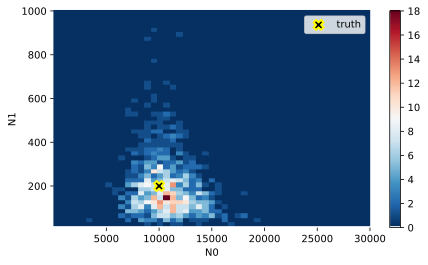

In [5]:
# Use SVG as the output format for notebooks.
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=plt.figaspect(9 / 16))
_,_,_,h = ax.hist2d(
    N0,
    N1,
    bins=(np.linspace(10, 30_000, 50), np.linspace(10, 1_000, 50)),
    cmap="RdBu_r",
    rasterized=True,
)
fig.colorbar(h, ax=ax)

ax.scatter(
    10_000, 200, marker="X", s=100, lw=2, fc="black", ec="yellow", label="truth"
)
ax.legend()
ax.set_xlabel("N0")
ax.set_ylabel("N1")

for sp in ("top", "right", "bottom", "left"):
    ax.spines[sp].set_visible(False)